In [1]:
import os
import glob
import random
import re
import pickle
import gc

import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKeras

import tqdm

import cv2

import tensorflow as tf

from tensorflow.keras import layers, models, callbacks
from tensorflow.image import resize_with_pad

from tensorflow.keras.preprocessing.image import (
    load_img, 
    img_to_array, 
    ImageDataGenerator,
    array_to_img,
    save_img
)

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [3]:
TARGET_HEIGHT = 224
TARGET_WIDTH = 224

# ===================

# This is where the NN modelling will go
## For NN modelling I will use the train-val-test set obtained from splitfolders 

In [4]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
)

In [5]:
#batch_size = 256

train_gen = datagen.flow_from_directory(
    'C:/temp_workfolder/rbc_keras/keras_split/train',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 64,
    class_mode = 'categorical',
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

val_gen = datagen.flow_from_directory(
    'C:/temp_workfolder/rbc_keras/keras_split/val',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 64,
    class_mode = 'categorical',
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

test_gen = datagen.flow_from_directory(
    'C:/temp_workfolder/rbc_keras/keras_split/test',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 64,
    class_mode = 'categorical',   #'categorical'
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

Found 4261 images belonging to 9 classes.
Found 1418 images belonging to 9 classes.
Found 1429 images belonging to 9 classes.


In [19]:
train_gen.class_indices

{'acantocyte': 0,
 'elliptocyte': 1,
 'hypochromic': 2,
 'normal': 3,
 'pencil': 4,
 'spero_bulat': 5,
 'stomatocyte': 6,
 'targetsel': 7,
 'teardrop': 8}

In [20]:
#train_gen.filenames[1000:1010]

In [6]:
X_train, Y_train = next(train_gen)
print(X_train.shape)
print(Y_train.shape)

(64, 224, 224, 3)
(64, 9)


In [7]:
X_val, Y_val = next(val_gen)
print(X_val.shape)
print(Y_val.shape)

(64, 224, 224, 3)
(64, 9)


In [8]:
X_test, Y_test = next(test_gen)
print(X_test.shape)
print(Y_test.shape)

(64, 224, 224, 3)
(64, 9)


In [16]:
resnet_model = ResNet50(weights=None, classes=9, include_top=True)#, input_shape=(96, 96, 3))
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
print(resnet_model.summary())
gc.collect()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

33380

In [18]:
gc.collect()

0

In [88]:
res_img_path = 'C:/temp_workfolder/rbc_keras/keras_split/test/elliptocyte/T3-K1-0049 objek#27.png'
res_img = load_img(res_img_path, target_size=(224, 224))
res_x = img_to_array(res_img)
res_x = np.expand_dims(res_x, axis=0)
res_x = preprocess_input(res_x)

res_pred = resnet_model.predict(res_x)

print('Predicted:', decode_predictions(res_pred, top=3)[0])

Predicted: [('n01930112', 'nematode', 0.2494993), ('n02317335', 'starfish', 0.23845997), ('n02321529', 'sea_cucumber', 0.19629721)]


In [63]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
inception_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_188 (Conv2D)            (None, 47, 47, 32)   864         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 47, 47, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_188 (Activation)    (None, 47, 47, 32)   0           ['batch_normalization_

In [25]:
vgg16_model = VGG16(include_top=True,
                    #input_shape=(TARGET_HEIGHT,TARGET_WIDTH,3),
                    weights=None,
                    classes=9)
vgg16_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
gc.collect()
vgg16_model.summary()
gc.collect()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

1333

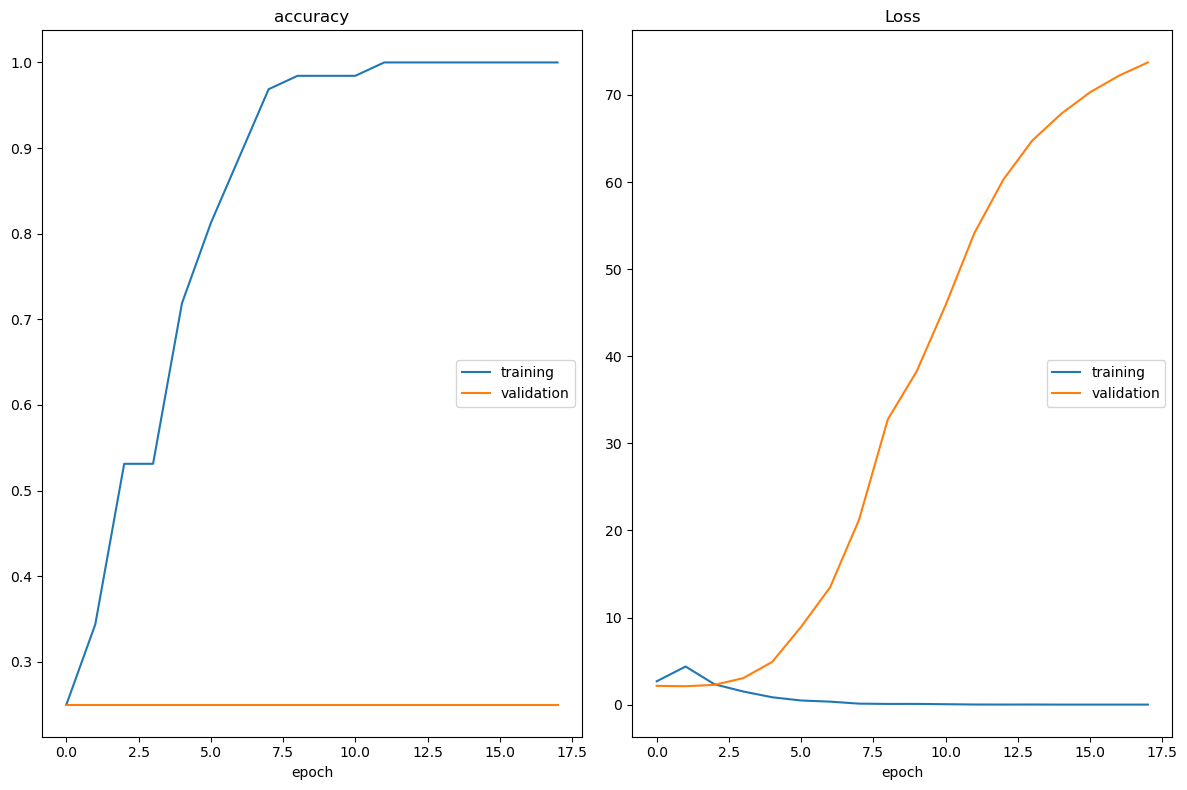

accuracy
	training         	 (min:    0.250, max:    1.000, cur:    1.000)
	validation       	 (min:    0.250, max:    0.250, cur:    0.250)
Loss
	training         	 (min:    0.002, max:    4.376, cur:    0.003)
	validation       	 (min:    2.114, max:   73.727, cur:   73.727)
2/2 [==============================] - 1s 707ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 73.7268 - val_accuracy: 0.2500


97760

In [19]:

resnet_model.fit(X_train,
               Y_train,
               epochs=100,
               #steps_per_epoch=32,
               validation_data=(X_val,Y_val),
               validation_freq=1,
               callbacks=[EarlyStopping(patience=16, verbose=0),PlotLossesKeras()]
              )
gc.collect()


In [22]:
gc.collect()


1310

In [21]:
resnet_model.evaluate(X_test, Y_test)

2/2 [==============================] - 1s 89ms/step - loss: 69.3543 - accuracy: 0.2812


[69.35429382324219, 0.28125]

In [23]:
resnet_model.predict(X_test)

array([[1.46884395e-30, 4.67606930e-37, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.86590339e-30, 0.00000000e+00, 1.59094721e-21,
        1.00000000e+00],
       [9.95463253e-31, 2.76161601e-37, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.19350708e-30, 0.00000000e+00, 1.23908283e-21,
        1.00000000e+00],
       [9.24256225e-31, 2.43704323e-37, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.75715003e-30, 0.00000000e+00, 1.19590404e-21,
        1.00000000e+00],
       [1.60450691e-30, 5.27516453e-37, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.65738612e-30, 0.00000000e+00, 1.68642437e-21,
        1.00000000e+00],
       [1.65929604e-30, 5.50971364e-37, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.95467447e-30, 0.00000000e+00, 1.72506053e-21,
        1.00000000e+00],
       [9.07362021e-31, 2.39085486e-37, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.64248084e-30, 0.00000000e+00, 1.17575646e-21,
        1.0

In [24]:
# Assigns the most likely class for each image

y_pred = np.argmax(resnet_model.predict(X_test), axis=-1)

In [25]:
print(test_gen.class_indices)
y_pred[:]

{'acantocyte': 0, 'elliptocyte': 1, 'hypochromic': 2, 'normal': 3, 'pencil': 4, 'spero_bulat': 5, 'stomatocyte': 6, 'targetsel': 7, 'teardrop': 8}


array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
      dtype=int64)

In [26]:
# The smae procedure for the 'actual' data

Y_test_multilabel = np.argmax(Y_test, axis=-1)

In [27]:
Y_test_multilabel[:]

array([1, 8, 3, 2, 7, 5, 5, 3, 0, 3, 2, 7, 8, 8, 1, 8, 1, 1, 1, 0, 0, 3,
       8, 3, 1, 2, 1, 6, 8, 7, 1, 8, 8, 5, 7, 8, 0, 1, 8, 8, 8, 7, 8, 8,
       8, 2, 0, 7, 8, 3, 4, 0, 5, 3, 5, 6, 3, 8, 7, 6, 8, 6, 7, 6],
      dtype=int64)

In [28]:
#model_confusion_matrix = multilabel_confusion_matrix(Y_test_multilabel, y_pred)
model_confusion_matrix = confusion_matrix(Y_test_multilabel, y_pred)

In [29]:
model_confusion_matrix

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  9],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  8],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  8],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 18]], dtype=int64)

Text(95.72222222222221, 0.5, 'Actual')

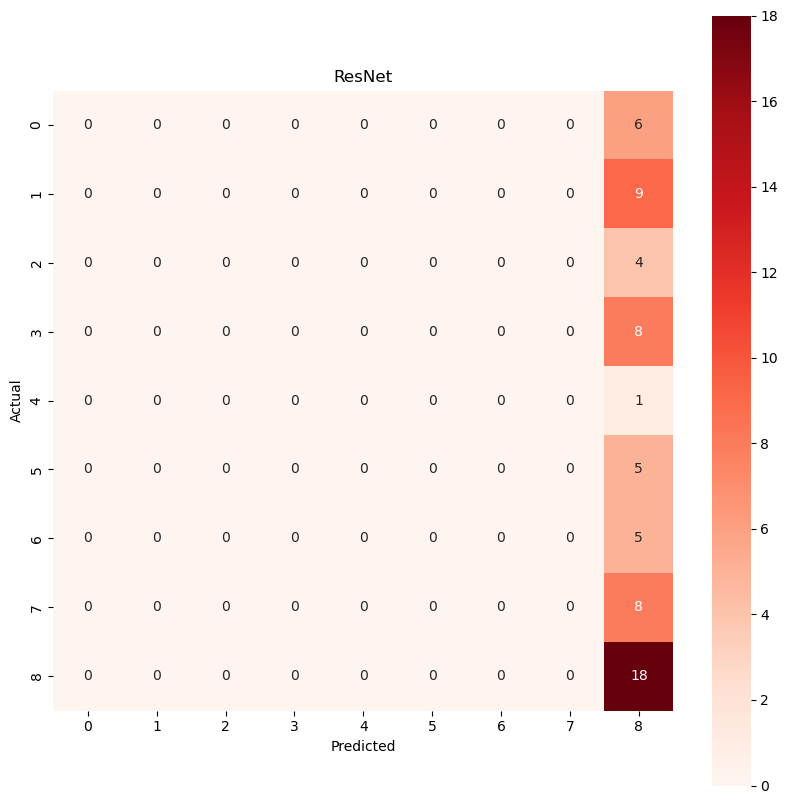

In [31]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(model_confusion_matrix, cmap='Reds', annot=True, square=True, fmt='d')
plt.title("ResNet")    
plt.xlabel('Predicted')
plt.ylabel('Actual')